In [1]:
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from models.dpt import DPT
from models.uformer import UformerSimple
from dataloaders.ColorizationDataset import ColorizationDataset
import pickle

In [2]:
train_set = ColorizationDataset(train=True)
validation_set = ColorizationDataset(train=False)
print(len(train_set), len(validation_set))
loss_fn = lambda pred, gt: torch.sum((pred - gt) ** 2, dim=1).mean()

5717 5823


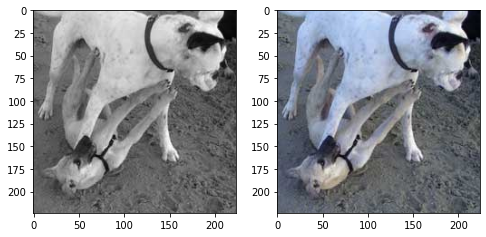

In [3]:
# Colorization example (DPT)
def show_image(idx: int):
    gray, color = train_set[idx]
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(gray.transpose((1, 2, 0)))
    ax[1].imshow(color.transpose((1, 2, 0)))
show_image(2)

tensor(18.2233)


/home/eecs/jiarui.shan/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


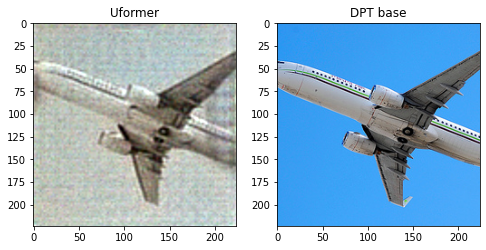

In [16]:
dpt_model = DPT(3).cuda()
dpt_model.load_state_dict(torch.load('checkpoints/color-dpt-base/model.pt'))
gray, color = train_set[5]
pred = dpt_model(torch.tensor(gray).cuda().unsqueeze(0))[0].detach().cpu()
print(loss_fn(pred, torch.tensor(color)))
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].set_title('DPT base')
ax[1].set_title('Groundtruth')
ax[0].imshow(torch.clamp(pred.permute(1, 2, 0), 0, 1))
ax[1].imshow(torch.tensor(color).permute(1, 2, 0))

tensor(14.9106)


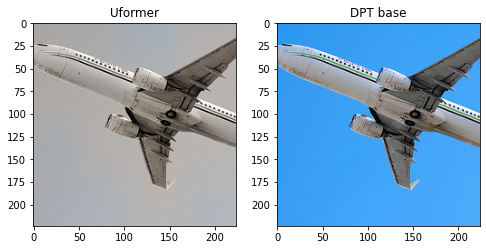

In [15]:
uformer_model = UformerSimple().cuda()
uformer_model.load_state_dict(torch.load('checkpoints/uformer-color/model.pt'))
gray, color = train_set[5]
pred = uformer_model(torch.tensor(gray).cuda().unsqueeze(0))[0].detach().cpu()
print(loss_fn(pred, torch.tensor(color)))

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].set_title('Uformer')
ax[1].set_title('DPT base')
ax[0].imshow(torch.clamp(pred.permute(1, 2, 0), 0, 1))
ax[1].imshow(torch.tensor(color).permute(1, 2, 0))

In [15]:
window_size = 4
coords_h = torch.arange(window_size) # [0,...,Wh-1]
coords_w = torch.arange(window_size) # [0,...,Ww-1]
coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
coords_flatten = torch.flatten(coords, 1)
coords_flatten

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]])

In [16]:
bias_table = torch.arange((2 * window_size - 1) ** 2).unsqueeze(-1)
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
print(relative_coords.shape)
relative_coords[:, :, 0] += window_size - 1  # shift to start from 0
relative_coords[:, :, 1] += window_size - 1
relative_coords[:, :, 0] *= 2 * window_size - 1
relative_position_index = relative_coords.sum(-1)
relative_coords.shape, relative_position_index.shape, torch.max(relative_position_index)

torch.Size([16, 16, 2])


(torch.Size([16, 16, 2]), torch.Size([16, 16]), tensor(48))

In [20]:
relative_position_bias = bias_table[relative_position_index.view(-1)].view(window_size ** 2, window_size ** 2, -1)
relative_position_bias = relative_position_bias.permute(2, 0, 1)
ratio = window_size ** 2 //relative_position_bias.size(-1)
print(relative_position_bias.shape)
relative_position_bias
# relative_position_bias = einops.repeat(relative_position_bias, 'nH l c -> nH l (c d)', d = ratio)
# print(relative_position_bias.shape, ratio)
relative_position_bias.shape, ratio

torch.Size([1, 16, 16])


(torch.Size([1, 16, 16]), 1)

In [1]:
def plot_learning_curve(model_name: str):
    with open(f"{model_name}/stats.pk", 'rb') as f:
        data = pickle.load(f)
    train_loss = [x['train_loss'] for x in data]
    eval_loss = [x['eval_loss'] for x in data]
    epochs = [x['epoch'] for x in data]
    plt.figure(figsize=(8, 5), facecolor='white')
    plt.title('Eval loss over time')
    plt.plot(epochs, train_loss, alpha=0.6, label='Train loss')
    plt.plot(epochs, eval_loss, alpha=0.6, label='Eval loss')
    plt.legend()
plot_learning_curve('checkpoints/color-dpt-base')

NameError: name 'pickle' is not defined

In [6]:
sum(p.numel() for p in dpt_model.parameters())

112501422